In [1]:
import matplotlib.pyplot as plt
import numpy as np
import data_utils
from collections import Counter
from tqdm import tqdm

# Set plot style
plt.style.use('ggplot')

In [2]:
def collect_token_stats(file_path, total_lines=None):
    """
    Scan file and count tokens using data_utils.
    """
    zh_counter = Counter()
    en_counter = Counter()
    
    print(f"Scanning {file_path} ...")
    generator = data_utils.load_jsonl_generator(file_path)
    
    for item in tqdm(generator, total=total_lines, desc="Tokenizing & Counting"):
        zh_tokens = data_utils.tokenize(item['zh'], 'zh')
        en_tokens = data_utils.tokenize(item['en'], 'en')
        
        zh_counter.update(zh_tokens)
        en_counter.update(en_tokens)
        
    return zh_counter, en_counter

In [3]:
def analyze_and_plot(counter, lang_name):
    """
    Analyze coverage, print top words, and plot distribution.
    """
    # 1. Prepare Data
    sorted_words = counter.most_common()
    counts = np.array([c for w, c in sorted_words])
    total_tokens = np.sum(counts)
    vocab_size = len(counts)
    
    # Cumulative Sum
    cumsum = np.cumsum(counts)
    coverage_percentages = cumsum / total_tokens
    
    print(f"\n{'='*20} {lang_name} Analysis {'='*20}")
    print(f"Total Tokens: {total_tokens}")
    print(f"Vocab Size:   {vocab_size}")
    
    # 1. Print Top 20 Words (Sanity Check)
    print(f"\n[Top 20 Frequent Tokens]")
    # Print in a single line or wrapped for compactness
    top_20 = [f"'{w}':{c}" for w, c in sorted_words[:20]]
    print(", ".join(top_20))
    
    # 2. Coverage Thresholds
    print("\n[Metrics 1] Vocabulary Size needed for Coverage:")
    thresholds = [0.90, 0.95, 0.98, 0.99, 0.995]
    for t in thresholds:
        idx = np.searchsorted(coverage_percentages, t)
        print(f"   Cover {t*100:5.1f}% needs Top {idx+1:6d} words")

    # 3. Min Frequency Cutoff
    print("\n[Metrics 2] Vocab Size vs. Min Frequency:")
    min_freqs = [1, 2, 3, 5, 8, 10, 20]
    for mf in min_freqs:
        kept_vocab = np.sum(counts >= mf)
        kept_tokens = np.sum(counts[counts >= mf])
        coverage = kept_tokens / total_tokens
        print(f"   Min Freq >= {mf:2d}: Vocab Size = {kept_vocab:6d} (Coverage: {coverage:.2%})")

    # 4. Visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot 1: Log-Log Frequency (Zipf's Law)
    ax1.plot(np.arange(vocab_size), counts, color='tab:blue', alpha=0.8)
    ax1.set_yscale('log')
    ax1.set_xscale('log')
    ax1.set_title(f'{lang_name} Word Frequency (Log-Log)')
    ax1.set_xlabel('Rank')
    ax1.set_ylabel('Frequency')
    ax1.grid(True, which="both", alpha=0.3)
    
    # Plot 2: Cumulative Coverage
    limit = min(30000, vocab_size)
    ax2.plot(np.arange(limit), coverage_percentages[:limit], color='tab:green', linewidth=2)
    
    # Add guidelines
    colors = ['orange', 'red', 'purple']
    lines = [0.95, 0.98, 0.99]
    for threshold, color in zip(lines, colors):
        idx = np.searchsorted(coverage_percentages, threshold)
        if idx < limit:
            ax2.axvline(x=idx, color=color, linestyle='--', label=f'{threshold*100}% @ {idx}')
            ax2.axhline(y=threshold, color=color, linestyle=':', alpha=0.5)
            
    ax2.set_title(f'{lang_name} Cumulative Coverage')
    ax2.set_xlabel('Vocabulary Size (Top N words)')
    ax2.set_ylabel('Coverage Ratio')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

In [4]:
file_path = './data/train_100k.jsonl'
zh_counter, en_counter = collect_token_stats(file_path, total_lines=100000)

Scanning ./data/train_100k.jsonl ...


Tokenizing & Counting:   0%|          | 0/100000 [00:00<?, ?it/s]Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.420 seconds.
Prefix dict has been built successfully.
Tokenizing & Counting: 100%|██████████| 100000/100000 [00:24<00:00, 4024.47it/s]



==================== Chinese (Jieba) Analysis ====================
Total Tokens: 2355952
Vocab Size:   59034

[Top 20 Frequent Tokens]
'的':163179, ',':115817, '。':97169, '和':32137, '在':31629, '—':27717, '是':24494, '了':23496, '、':15174, '但':12343, '也':12038, '将':10892, ')':10642, '(':10641, '而':10467, '对':10359, '美国':10326, '中国':9901, '这':9129, '“':9121

[Metrics 1] Vocabulary Size needed for Coverage:
   Cover  90.0% needs Top   4997 words
   Cover  95.0% needs Top  11147 words
   Cover  98.0% needs Top  23993 words
   Cover  99.0% needs Top  35475 words
   Cover  99.5% needs Top  47255 words

[Metrics 2] Vocab Size vs. Min Frequency:
   Min Freq >=  1: Vocab Size =  59034 (Coverage: 100.00%)
   Min Freq >=  2: Vocab Size =  34101 (Coverage: 98.94%)
   Min Freq >=  3: Vocab Size =  25963 (Coverage: 98.25%)
   Min Freq >=  5: Vocab Size =  18679 (Coverage: 97.20%)
   Min Freq >=  8: Vocab Size =  13753 (Coverage: 95.98%)
   Min Freq >= 10: Vocab Size =  11884 (Coverage: 95.31%)
   Min 

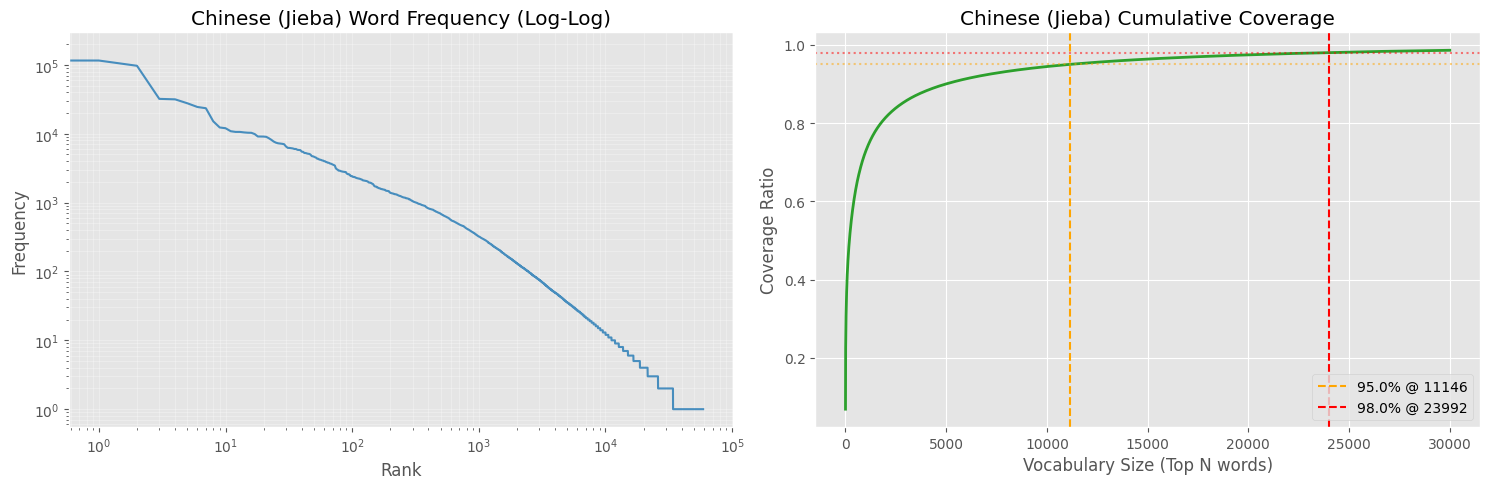

In [5]:
analyze_and_plot(zh_counter, "Chinese (Jieba)")


==================== English (NLTK) Analysis ====================
Total Tokens: 2533798
Vocab Size:   46499

[Top 20 Frequent Tokens]
',':137144, 'the':136333, '.':96527, 'to':66636, 'of':65099, 'and':61971, 'in':48245, 'a':42273, 'that':31331, 'is':29690, '’':28196, 's':24276, 'for':21030, '–':16976, 'it':15474, 'as':15379, 'be':14687, 'on':13763, 'are':13716, 'with':13199

[Metrics 1] Vocabulary Size needed for Coverage:
   Cover  90.0% needs Top   3983 words
   Cover  95.0% needs Top   8258 words
   Cover  98.0% needs Top  16672 words
   Cover  99.0% needs Top  24901 words
   Cover  99.5% needs Top  33831 words

[Metrics 2] Vocab Size vs. Min Frequency:
   Min Freq >=  1: Vocab Size =  46499 (Coverage: 100.00%)
   Min Freq >=  2: Vocab Size =  28639 (Coverage: 99.30%)
   Min Freq >=  3: Vocab Size =  22626 (Coverage: 98.82%)
   Min Freq >=  5: Vocab Size =  16989 (Coverage: 98.06%)
   Min Freq >=  8: Vocab Size =  13083 (Coverage: 97.16%)
   Min Freq >= 10: Vocab Size =  11542 (Cov

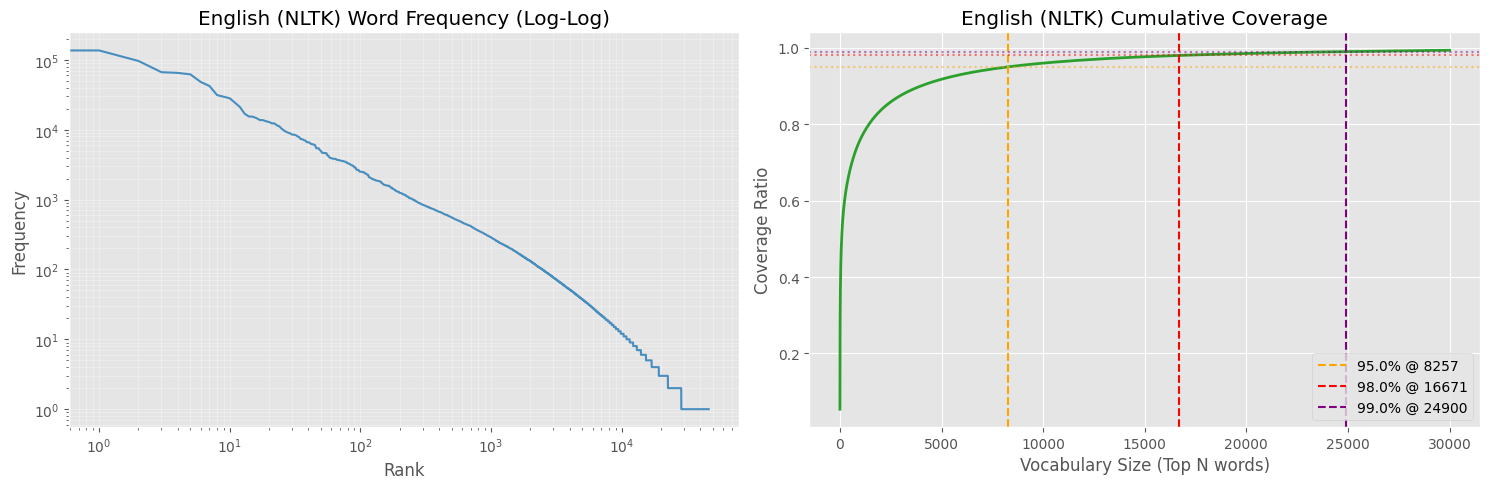

In [6]:
analyze_and_plot(en_counter, "English (NLTK)")

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import data_utils
from tqdm import tqdm

In [8]:
def analyze_lengths(file_path):
    print(f"Scanning {file_path} for length statistics...")
    
    zh_lengths = []
    en_lengths = []
    
    # Use generator to read data
    generator = data_utils.load_jsonl_generator(file_path)
    
    for item in tqdm(generator, desc="Measuring lengths"):
        # 1. Tokenize
        tokens_zh = data_utils.tokenize(item['zh'], 'zh')
        tokens_en = data_utils.tokenize(item['en'], 'en')
        
        # 2. Record lengths
        zh_lengths.append(len(tokens_zh))
        en_lengths.append(len(tokens_en))
        
    return np.array(zh_lengths), np.array(en_lengths)

In [9]:
def plot_length_distribution(lengths, lang_name, color):
    """
    Plot histogram and print percentiles.
    """
    plt.figure(figsize=(10, 6))
    
    # Basic Statistics
    max_len = np.max(lengths)
    mean_len = np.mean(lengths)
    
    # Percentiles
    p90 = np.percentile(lengths, 90)
    p95 = np.percentile(lengths, 95)
    p98 = np.percentile(lengths, 98)
    p99 = np.percentile(lengths, 99)
    p999 = np.percentile(lengths, 99.9)
    
    print(f"\n{'='*10} {lang_name} Length Statistics {'='*10}")
    print(f"Max Length:   {max_len}")
    print(f"Mean Length:  {mean_len:.2f}")
    print(f"---------------------------")
    print(f"Cover 90.0% data: <= {int(p90)}")
    print(f"Cover 95.0% data: <= {int(p95)}")
    print(f"Cover 98.0% data: <= {int(p98)}")
    print(f"Cover 99.0% data: <= {int(p99)}")
    print(f"Cover 99.9% data: <= {int(p999)}")
    
    # Plot
    plt.hist(lengths, bins=50, color=color, alpha=0.7, edgecolor='black')
    plt.axvline(p95, color='orange', linestyle='--', linewidth=2, label=f'95% ({int(p95)})')
    plt.axvline(p99, color='red', linestyle='--', linewidth=2, label=f'99% ({int(p99)})')
    
    plt.title(f'{lang_name} Sentence Length Distribution')
    plt.xlabel('Length (Number of Tokens)')
    plt.ylabel('Count')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

In [10]:
FILE_PATH = './data/train_100k.jsonl' 
zh_lens, en_lens = analyze_lengths(FILE_PATH)

Scanning ./data/train_100k.jsonl for length statistics...


Measuring lengths: 100000it [00:24, 4160.59it/s]



========== Chinese Length Statistics ==========
Max Length:   135
Mean Length:  23.56
---------------------------
Cover 90.0% data: <= 39
Cover 95.0% data: <= 45
Cover 98.0% data: <= 52
Cover 99.0% data: <= 57
Cover 99.9% data: <= 75


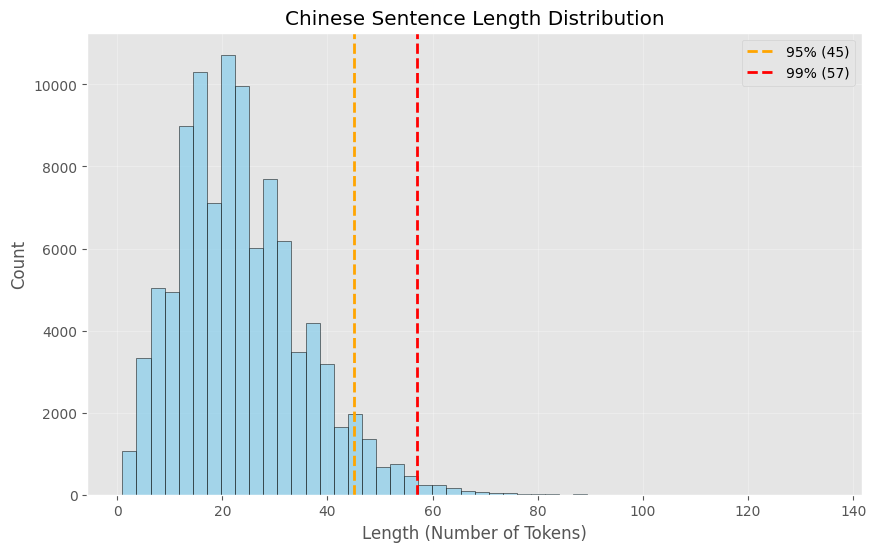

In [11]:
plot_length_distribution(zh_lens, "Chinese", "skyblue")


========== English Length Statistics ==========
Max Length:   132
Mean Length:  25.34
---------------------------
Cover 90.0% data: <= 42
Cover 95.0% data: <= 48
Cover 98.0% data: <= 54
Cover 99.0% data: <= 59
Cover 99.9% data: <= 76


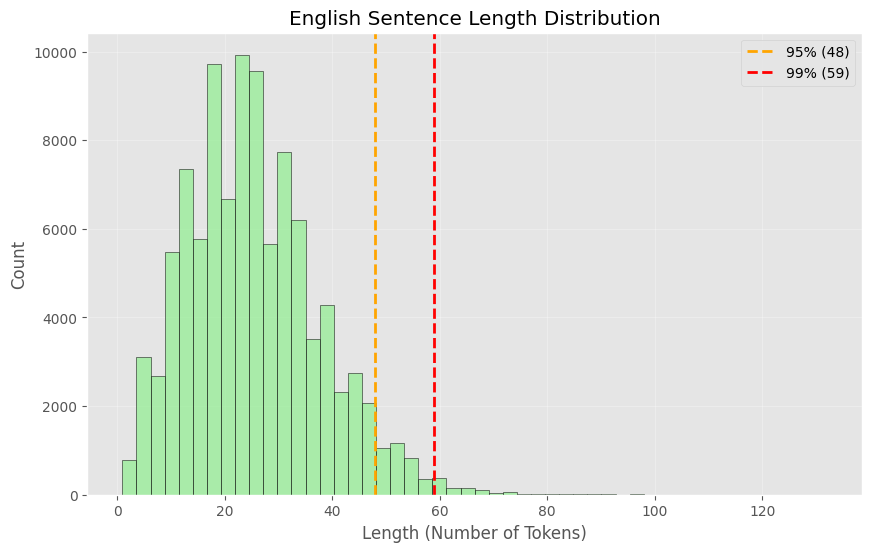

In [12]:
plot_length_distribution(en_lens, "English", "lightgreen")

In [13]:
print(f"\nGlobal Max Length (ZH or EN): {max(np.max(zh_lens), np.max(en_lens))}")


Global Max Length (ZH or EN): 135


In [14]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from tokenizers import ByteLevelBPETokenizer
from tokenizers.processors import BertProcessing

In [15]:

# Set plot style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

# 1. Define Paths
VOCAB_DIR = "./bpe_vocab"
DATA_FILE = "./data/train_100k.jsonl"

# 2. Load Tokenizer
print("Loading Tokenizer...")
tokenizer = ByteLevelBPETokenizer(
    os.path.join(VOCAB_DIR, "vocab.json"),
    os.path.join(VOCAB_DIR, "merges.txt")
)

# 3. Configure Post-Processor to include special tokens in length count
sos_id = tokenizer.token_to_id("<s>")
eos_id = tokenizer.token_to_id("</s>")

tokenizer._tokenizer.post_processor = BertProcessing(
    ("</s>", eos_id),
    ("<s>", sos_id),
)

print("Tokenizer loaded successfully.")

Loading Tokenizer...
Tokenizer loaded successfully.


In [16]:
zh_lengths = []
en_lengths = []

print(f"Scanning {DATA_FILE} ...")

with open(DATA_FILE, 'r', encoding='utf-8') as f:
    for line in tqdm(f, desc="Tokenizing"):
        line = line.strip()
        if not line: continue
        
        try:
            item = json.loads(line)
        except json.JSONDecodeError:
            continue
            
        # Encode (Fast BPE)
        # IDs list already includes <s> and </s> because of BertProcessing
        enc_zh = tokenizer.encode(item['zh']).ids
        enc_en = tokenizer.encode(item['en']).ids
        
        zh_lengths.append(len(enc_zh))
        en_lengths.append(len(enc_en))

zh_lengths = np.array(zh_lengths)
en_lengths = np.array(en_lengths)

print(f"\nScanned {len(zh_lengths)} samples.")

Scanning ./data/train_100k.jsonl ...


Tokenizing: 100000it [00:11, 8470.40it/s]


Scanned 100000 samples.


In [17]:
def print_stats(name, lengths):
    print(f"=== {name} Length Statistics ===")
    print(f"Min: {np.min(lengths)}")
    print(f"Max: {np.max(lengths)}")
    print(f"Mean: {np.mean(lengths):.2f}")
    print(f"Median: {np.median(lengths)}")
    
    # Percentiles / 分位数
    for p in [90, 95, 98, 99, 99.5, 99.9]:
        val = np.percentile(lengths, p)
        print(f"Top {p}% coverage length: {int(val)}")
    print("-" * 30)

print_stats("Chinese (Source)", zh_lengths)
print_stats("English (Target)", en_lengths)

# Suggest Max Length / 建议最大长度
# Usually we take the max of 99% or 99.5% of both languages
p99_zh = np.percentile(zh_lengths, 99.9)
p99_en = np.percentile(en_lengths, 99.9)
suggested_max = max(p99_zh, p99_en)

print(f"\n>>> Suggested MAX_LEN (covering 99.9% data): {int(suggested_max)}")

=== Chinese (Source) Length Statistics ===
Min: 3
Max: 198
Mean: 30.86
Median: 28.0
Top 90% coverage length: 51
Top 95% coverage length: 60
Top 98% coverage length: 70
Top 99% coverage length: 78
Top 99.5% coverage length: 87
Top 99.9% coverage length: 109
------------------------------
=== English (Target) Length Statistics ===
Min: 3
Max: 202
Mean: 36.18
Median: 34.0
Top 90% coverage length: 59
Top 95% coverage length: 68
Top 98% coverage length: 79
Top 99% coverage length: 86
Top 99.5% coverage length: 94
Top 99.9% coverage length: 114
------------------------------

>>> Suggested MAX_LEN (covering 99.9% data): 114


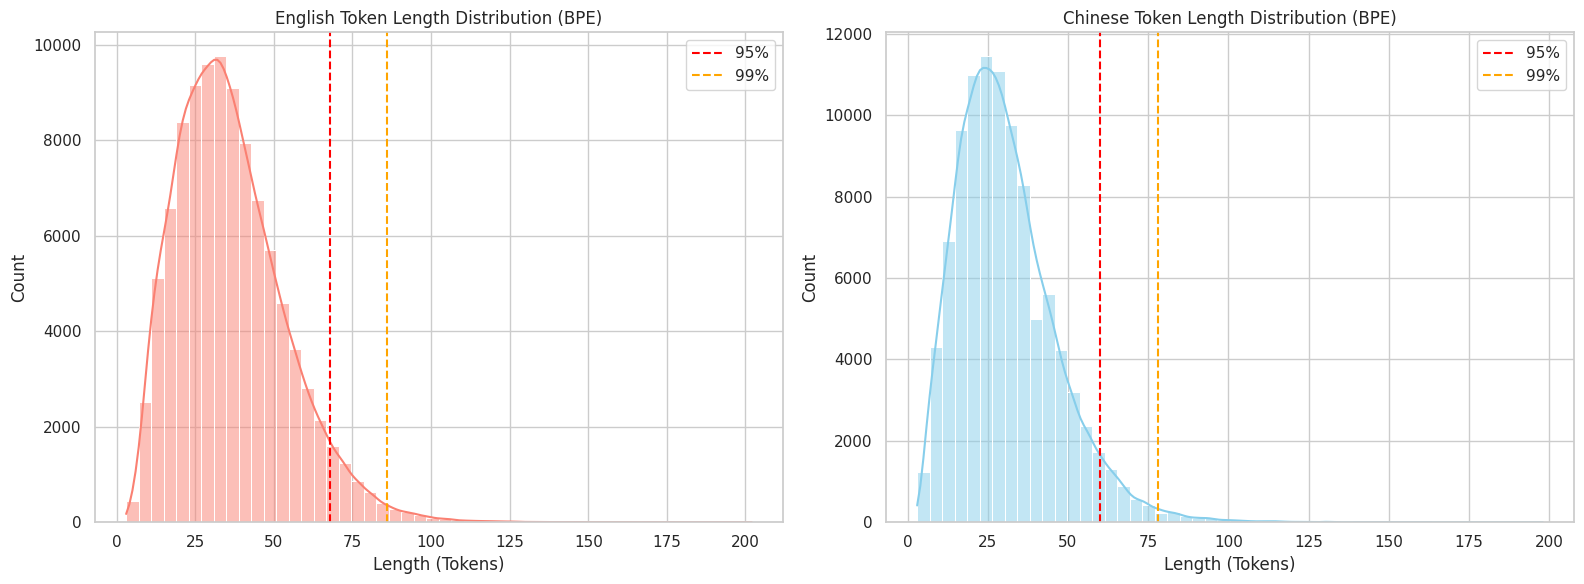

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))


# English Distribution 
sns.histplot(en_lengths, bins=50, kde=True, color='salmon', ax=ax1)
ax1.set_title('English Token Length Distribution (BPE)')
ax1.set_xlabel('Length (Tokens)')
ax1.set_ylabel('Count')
ax1.axvline(np.percentile(en_lengths, 95), color='red', linestyle='--', label='95%')
ax1.axvline(np.percentile(en_lengths, 99), color='orange', linestyle='--', label='99%')
ax1.legend()

# Chinese Distribution
sns.histplot(zh_lengths, bins=50, kde=True, color='skyblue', ax=ax2)
ax2.set_title('Chinese Token Length Distribution (BPE)')
ax2.set_xlabel('Length (Tokens)')
ax2.set_ylabel('Count')
ax2.axvline(np.percentile(zh_lengths, 95), color='red', linestyle='--', label='95%')
ax2.axvline(np.percentile(zh_lengths, 99), color='orange', linestyle='--', label='99%')
ax2.legend()


plt.tight_layout()
plt.show()